In [1]:
!pip install pydicom
!pip install pydrive
!pip install --upgrade tables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2
import glob
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import multiprocessing
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn.decomposition import FactorAnalysis
from mpl_toolkits.mplot3d import Axes3D

     |████████████████████████████████| 35.3MB 87kB/s 
     |████████████████████████████████| 4.3MB 2.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [0]:
#for drive and colab connectivity
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1X68NtrH6W_d2aR6tzYwZjKsff_c4WA75"})   # replace the id with id of file you want to access
downloaded.GetContentFile('stage_2_train_labels.csv')        # replace the file name with your file

#change path
# path= ""
labels = pd.read_csv('stage_2_train_labels.csv')

In [0]:
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


# saving image_array

In [0]:
arry = []
num_sample = 30228

def read_image(image_direc, num_sample):
    temp = []
    for filename in tqdm(labels['patientId'].tolist()[num_sample:]):
        meta_file = pydicom.read_file(path+ image_direc+ filename+'.dcm')
        temp.append(meta_file)
        
    return temp

    
def processInput(filename, IMG_PX_SIZE): 
    
    OI = filename.pixel_array
    resized_img = resize(OI, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)

    return resized_img

In [0]:
#don't run this cell if you're loading image array from the saved file 
data = read_image('data/stage_2_train_images/', num_sample)
arry.append(Parallel(n_jobs= -1)(delayed(processInput)(file, 256) for file in tqdm(data)))

In [0]:
#don't run this cell if you're loading image array from the saved file 
store_df = pd.DataFrame(arry).T
store_df.to_hdf('D:/store.h5', key='store_df', mode='w')

In [0]:
# np.save('D:/test1', arry)
# np_array = np.load('D:/test1.npy')

# reading saved image_array and visualization

In [0]:
downloaded = drive.CreateFile({'id':"1G2Ig6FM2XbBrvCcTeWBPNNx6SgDu5BOE"})   # replace the id with id of file you want to access
downloaded.GetContentFile('store.h5')        # replace the file name with your file
stor_df1 = pd.read_hdf('store.h5')

In [0]:
downloaded = drive.CreateFile({'id':"1DaHE0tY757Jjl-0iiT0wX74t4Ko-yGj9"})   # replace the id with id of file you want to access
downloaded.GetContentFile('store222.h5')        # replace the file name with your file
stor_df2 = pd.read_hdf('store222.h5')

stor_df = pd.concat([stor_df1,stor_df2],ignore_index=True)

In [0]:
k_temp = [i[0] for i in stor_df.values]
stor_df.head()

,0
0,"[[0.1607843137254884, 0.05098039215686184, 0.0..."
1,"[[0.03137254901960695, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,"[[0.054901960784313725, 0.050980392156862744, ..."
3,"[[0.6656862745098032, 0.5960784313725481, 0.54..."
4,"[[0.00392156862745098, 0.00784313725490196, 0...."


In [0]:
def plot_data(x, points_to_plot):
    
    x = x[:points_to_plot]
    transformer = FactorAnalysis(n_components=3, random_state=0)
    x_3d = np.array([transformer.fit_transform(i) for i in x])
    labell = labels.Target.values[:points_to_plot]
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x_3d[labell == 0][:500,0], x_3d[labell == 0][:500,1], x_3d[labell == 0][:500,2], label='Pneumonia', c='red', alpha=0.4)
    ax.scatter(x_3d[labell == 1][:500,0], x_3d[labell == 1][:500,1], x_3d[labell == 1][:500,2], label='No Pneumonia', c='blue', alpha=0.4)

    plt.legend()
    plt.show()

In [0]:
xtrain, xtest, ytrain, ytest = train_test_split(k_temp,labels['Target'].tolist()[:num_sample], test_size = 0.2)

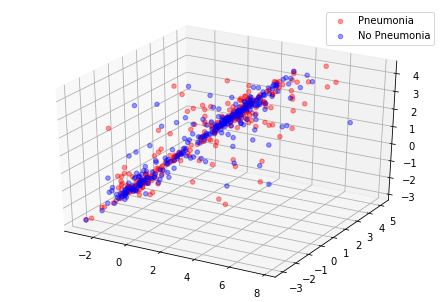

In [0]:
plot_data(xtrain,200)

# Models 

In [0]:
xtrain_flat = [i.flatten() for i in xtrain]     
xtest_flat = [i.flatten() for i in xtest]

In [0]:
def plots(model, X_test, y_test):
    
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [0]:
clf1 = LogisticRegression()
clf1.fit(xtrain_flat, ytrain)
y_pred1 = clf1.predict(xtest_flat)

ValueError: ignored

In [0]:
print('Model: LR')
print('-'*100)
print('Accuracy: train: ', clf1.score(xtrain_flat, ytrain))
print('Accuracy: test: ', clf1.score(xtest_flat, ytest))
print('\n')
print('confusion matrix:')
print(confusion_matrix(ytest, y_pred1))
print('\n')
print('-'*100)
plots(clf1, xtest_flat, ytest)

In [0]:
clf2 = RandomForestClassifier()
clf2.fit(xtrain_flat, ytrain)
y_pred2 = clf2.predict(xtest_flat)

In [0]:
print('Model: RF')
print('-'*100)
print('Accuracy: train: ', clf2.score(xtrain_flat, ytrain))
print('Accuracy: test: ', clf2.score(xtest_flat, ytest))
print('confusion matrix:')
print(confusion_matrix(ytest, y_pred2))
print('\n')
print('-'*100)
plots(clf2, xtest_flat, ytest)

Model: RF
----------------------------------------------------------------------------------------------------


NameError: ignored

In [0]:
# !pip install tensorflow==1.14 
# !pip install keras_tqdm
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv1D, Activation, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Lambda
from keras.layers import MaxPooling1D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense
import keras.backend as K
from keras import optimizers

Using TensorFlow backend.


In [0]:
xtrain = np.array(xtrain)
xtest = np.array(xtest)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

batch_size = 128
num_epochs = 70


# def scale_data(matrix):
#   return np.array([normalize(x, axis=1, norm='l1') for x in matrix ])


    
model = Sequential()


model.add(Conv1D(filters = 32, kernel_size= (1), activation= 'relu',input_shape=(128,128),padding= 'same'))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters = 64, kernel_size= (1), activation= 'relu',padding= 'same'))
model.add(MaxPooling1D(2))

model.add(Conv1D(128,kernel_size= (1), activation='relu', padding= 'same'))
model.add(MaxPooling1D(1))

model.add(Conv1D(256,kernel_size= (1), activation='relu', padding= 'same'))
model.add(MaxPooling1D(1))

model.add(Conv1D(512,kernel_size= (1), activation='relu', padding= 'same'))
model.add(MaxPooling1D(1))

model.add(Flatten())

model.add(Dense(2, kernel_initializer='glorot_normal', activation='sigmoid'))




In [0]:
model.compile(loss = "binary_crossentropy", 
              optimizer = optimizers.Adam(lr=0.00001,beta_1=0.9, beta_2=0.999,decay=0.00001, amsgrad=True), 
              metrics=["accuracy"])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model.fit(x=xtrain, y=ytrain, validation_data=(xtest, ytest), batch_size=batch_size, epochs= num_epochs)




Train on 24181 samples, validate on 6046 samples
Epoch 1/70





24181/24181 [==============================] - 23s 950us/step - loss: 0.6271 - acc: 0.6835 - val_loss: 0.6112 - val_acc: 0.6854
Epoch 2/70
24181/24181 [==============================] - 7s 294us/step - loss: 0.6027 - acc: 0.6835 - val_loss: 0.5878 - val_acc: 0.6854
Epoch 3/70
24181/24181 [==============================] - 7s 293us/step - loss: 0.5692 - acc: 0.6837 - val_loss: 0.5440 - val_acc: 0.6865
Epoch 4/70
24181/24181 [==============================] - 7s 297us/step - loss: 0.5268 - acc: 0.7212 - val_loss: 0.5073 - val_acc: 0.7534
Epoch 5/70
24181/24181 [==============================] - 7s 297us/step - loss: 0.5038 - acc: 0.7532 - val_loss: 0.4958 - val_acc: 0.7672
Epoch 6/70
24181/24181 [==============================] - 7s 294us/step - loss: 0.4958 - acc: 0.7607 - val_loss: 0.4910 - val_acc: 0.7690
Epoch 7/70
24181/24181 [==============================] - 7s 292us/step - loss: 0.4917 - acc: 0.7628 - val_loss: 0